In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import googlemaps
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_formats = ['svg']
#sns.set(style='whitegrid', context='notebook')

import calendar
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import cPickle as pickle
import re

#visualization
import gmplot
import shapely
from mpl_toolkits.basemap import Basemap
import geopandas as gpd


## loading dataset

In [2]:
crime2016_raw = pd.read_csv('../dataset/SFPD2016.csv')

In [3]:
crime2016_raw.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,100475254,ASSAULT,BATTERY,Friday,08/26/2016,08:00,NORTHERN,"ARREST, BOOKED",UNION ST / GOUGH ST,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",10047525404134
1,100475254,WARRANTS,WARRANT ARREST,Friday,08/26/2016,08:00,NORTHERN,"ARREST, BOOKED",UNION ST / GOUGH ST,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",10047525463010


## cleaning dataset

In [4]:
#lowercase all columns and rows
crime2016 = crime2016_raw.apply(lambda x: x.astype(str).str.lower())
crime2016.columns = crime2016_raw.columns.str.lower()

In [5]:
#remove the non-criminal ones
crime2016 = crime2016[crime2016['category'] != 'non-criminal']

In [6]:
crime2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103095 entries, 0 to 117268
Data columns (total 13 columns):
incidntnum    103095 non-null object
category      103095 non-null object
descript      103095 non-null object
dayofweek     103095 non-null object
date          103095 non-null object
time          103095 non-null object
pddistrict    103095 non-null object
resolution    103095 non-null object
address       103095 non-null object
x             103095 non-null object
y             103095 non-null object
location      103095 non-null object
pdid          103095 non-null object
dtypes: object(13)
memory usage: 11.0+ MB


In [7]:
crime2016.head(1)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,location,pdid
0,100475254,assault,battery,friday,08/26/2016,08:00,northern,"arrest, booked",union st / gough st,-122.427270641,37.7981336021,"(37.7981336020854, -122.427270640646)",10047525404134


In [8]:
#create new time columns in useable format for future analysis
crime2016['new_time'] = crime2016['date'] + ' ' + crime2016['time']
crime2016['new_time'] = pd.to_datetime(crime2016['new_time'])

In [9]:
#create columns for month, day, and hour of each crime case
crime2016['hour'] = crime2016['new_time'].apply(lambda x: x.hour)
crime2016['day'] = crime2016['new_time'].apply(lambda x: x.day)
crime2016['month'] = crime2016['new_time'].apply(lambda x: x.month)

# making date column useable for analysis
crime2016['date'] = crime2016['new_time'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))

In [10]:
crime2016.head(1)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,location,pdid,new_time,hour,day,month
0,100475254,assault,battery,friday,2016-08-26,08:00,northern,"arrest, booked",union st / gough st,-122.427270641,37.7981336021,"(37.7981336020854, -122.427270640646)",10047525404134,2016-08-26 08:00:00,8,26,8


# adding in zipcodes using Google maps API

In [ ]:
# setting up API and use timeout to avoid excess average requests per second
gmaps = googlemaps.Client(key='key_for_API', timeout=60)

In [ ]:
# instead of running through over 100,000 locations
# only looking at unique locations, which are only 16,800 and 1/6 of the original amount
# save time and avoid going over API limit
crime_2016_geo = crime2016.copy()
uni = crime_2016_geo.drop_duplicates(subset='Location')
uni_loc = pd.DataFrame(uni['Location'])

In [ ]:
################################################################ 
# an example of how to get address from API and how to save it #
# next step would be extracting the zipcodes from API results  #
################################################################ 

#uni_loc0_2000 = uni_loc[:2000]
#uni_loc2000_2400 = uni_loc[2000:2400]
#uni_loc2400_4800 = uni_loc[2400:4800]
#uni_loc4800_7200 = uni_loc[4800:7200]
#uni_loc7200_9600 = uni_loc[7200:9600]
#uni_loc9600_12000 = uni_loc[9600:12000]
#uni_loc12000_14400 = uni_loc[12000:14400]
#uni_loc14400_16800 = uni_loc[14400:16800]
uni_loc16800 = uni_loc[16800:]

uni_loc16800['address'] = uni_loc16800['Location'].apply(lambda x: gmaps.reverse_geocode(eval(x), result_type=['street_address']))

with open('geo16800_end.pkl', 'wb') as handle:
    pickle.dump(uni_loc16800, handle)

In [11]:
# concat all the API results together

with open('../geo_reserve/google_api/geo0_2000.pkl', 'rb') as handle:
    geo0_2000 = pickle.load(handle)

with open('../geo_reserve/google_api/geo2000_2400.pkl', 'rb') as handle:
    geo2000_2400 = pickle.load(handle)

with open('../geo_reserve/google_api/geo2400_4800.pkl', 'rb') as handle:
    geo2400_4800 = pickle.load(handle)

with open('../geo_reserve/google_api/geo4800_7200.pkl', 'rb') as handle:
    geo4800_7200 = pickle.load(handle)

with open('../geo_reserve/google_api/geo7200_9600.pkl', 'rb') as handle:
    geo7200_9600 = pickle.load(handle)

with open('../geo_reserve/google_api/geo9600_12000.pkl', 'rb') as handle:
    geo9600_12000 = pickle.load(handle)

with open('../geo_reserve/google_api/geo12000_14400.pkl', 'rb') as handle:
    geo12000_14400 = pickle.load(handle)

with open('../geo_reserve/google_api/geo14400_16800.pkl', 'rb') as handle:
    geo14400_16800 = pickle.load(handle)

with open('../geo_reserve/google_api/geo16800_end.pkl', 'rb') as handle:
    geo16800_end = pickle.load(handle)

geo = pd.concat([geo0_2000, geo2000_2400, geo2400_4800, geo4800_7200, geo7200_9600, geo9600_12000, geo12000_14400,\
                geo14400_16800, geo16800_end])

In [12]:
geo.head(2)

,Location,address
0,"(37.7981336020854, -122.427270640646)",[{u'geometry': {u'location': {u'lat': 37.79805...
3,"(37.7724682400061, -122.389517648036)",[{u'geometry': {u'location': {u'lat': 37.77246...


In [13]:
geo['address'][0]

[{u'address_components': [{u'long_name': u'2660',
    u'short_name': u'2660',
    u'types': [u'street_number']},
   {u'long_name': u'Gough Street',
    u'short_name': u'Gough St',
    u'types': [u'route']},
   {u'long_name': u'Cow Hollow',
    u'short_name': u'Cow Hollow',
    u'types': [u'neighborhood', u'political']},
   {u'long_name': u'San Francisco',
    u'short_name': u'SF',
    u'types': [u'locality', u'political']},
   {u'long_name': u'San Francisco County',
    u'short_name': u'San Francisco County',
    u'types': [u'administrative_area_level_2', u'political']},
   {u'long_name': u'California',
    u'short_name': u'CA',
    u'types': [u'administrative_area_level_1', u'political']},
   {u'long_name': u'United States',
    u'short_name': u'US',
    u'types': [u'country', u'political']},
   {u'long_name': u'94123',
    u'short_name': u'94123',
    u'types': [u'postal_code']},
   {u'long_name': u'4416',
    u'short_name': u'4416',
    u'types': [u'postal_code_suffix']}],
  u'forma

In [ ]:
# add a new address column
geo['new_add'] = np.nan

# extract zipcode information from API results
# an example of what it looks like: u'long_name': u'94158', u'short_name': u'94158', u'types': [u'postal_code']
for i in geo['address'].index:
    if len(geo['address'][i]) > 0:
        geo['new_add'][i] = geo['address'][i][0]['address_components']
    else:
        pass

In [52]:
# finally, extract the exact zipcode
geo['zip'] = geo['new_add'].apply(lambda x: re.findall('94[0-9]{3}', str(x)))

# if there is no address or zipcode information, then fill in NA
def get_final_zip(x):
    if len(x) > 0:
        return x[0]
    else:
        return np.nan

geo['zipcode'] = geo['zip'].apply(lambda x: get_final_zip(x))

In [55]:
# make a clean dataframe for GPS locations and corresponding zipcodes 
geo_final = geo[['Location', 'zipcode']]
geo_final.columns = geo_final.columns.str.lower()

In [12]:
geo_final.head(2)

,location,zipcode
0,"(37.7981336020854, -122.427270640646)",94123
3,"(37.7724682400061, -122.389517648036)",94158


In [13]:
crime2016 = crime2016.merge(geo_final, how='left', on='location')
crime2016.head(1)

,incidntnum,category,descript,dayofweek,date,time,pddistrict,resolution,address,x,y,location,pdid,new_time,hour,day,month,zipcode
0,100475254,assault,battery,friday,2016-08-26,08:00,northern,"arrest, booked",union st / gough st,-122.427270641,37.7981336021,"(37.7981336020854, -122.427270640646)",10047525404134,2016-08-26 08:00:00,8,26,8,94123


# cleaning socioeconomic and demographic data


In [5]:
#loading dataset
demographic = pd.read_csv('../final_dataset/demographic_sf/sf_demographic_final.csv')
median_income = pd.read_csv('../final_dataset/demographic_sf/sf_median_income.csv')
median_home_value = pd.read_csv('../final_dataset/demographic_sf/sf_median_home_value.csv')
median_rent = pd.read_csv('../final_dataset/demographic_sf/sf_median_rent.csv')

In [ ]:
demographic['zipcode'] = demographic['zipcode'].apply(lambda x: str(x))
crime2016 = crime2016.merge(demographic, how='left', on='zipcode')

In [16]:
def extract_zipcode(df):
    df['zipcode'] = df['zipcode'].str.extract('([0-9]+)', expand=False)
    df.fillna('sf', inplace=True)
    return df

median_income = extract_zipcode(median_income)
median_home_value = extract_zipcode(median_home_value)
median_rent = extract_zipcode(median_rent)

In [17]:
crime2016 = crime2016.merge(median_income, how='left', on='zipcode')
crime2016 = crime2016.merge(median_home_value, how='left', on='zipcode')
crime2016 = crime2016.merge(median_rent, how='left', on='zipcode')

In [18]:
crime2016.dropna(inplace=True)
crime2016_complete_df = crime2016.drop(['incidntnum', 'descript', 'date', 'time', 'address', 'x', 'y', 'location',
              'resolution', 'pdid', 'race - one race', 'sex and age - under 5 years',
              'sex and age - total population','sex and age - 5 to 9 years', 'sex and age - 18 years and over',
              'sex and age - 21 years and over', 'sex and age - 62 years and over', 'sex and age - 65 years and over', 
              'race - two or more races',
              'race - race alone or in combination with one or more other races - total population - white',
              'race - race alone or in combination with one or more other races - total population - black or african american',
              'race - race alone or in combination with one or more other races - total population - american indian and alaska native',
              'race - race alone or in combination with one or more other races - total population - asian',
              'race - race alone or in combination with one or more other races - total population - native hawaiian and other pacific islander',
              'race - race alone or in combination with one or more other races - total population - some other race'], axis=1)

crime2016_complete_df = crime2016_complete_df.rename(columns={#'sex and age - total population': 'tol_pop',
                'sex and age - total population - male': 'tol_pop_male',
                'sex and age - total population - female': 'tol_pop_female',
                #'sex and age - under 5 years':'under_5',
                #'sex and age - 5 to 9 years': 'age5_9', 
                'sex and age - 10 to 14 years': 'age10_14',
                'sex and age - 15 to 19 years': 'age15_19', 
                'sex and age - 20 to 24 years': 'age20_24',
                'sex and age - 25 to 34 years': 'age25_34',
                'sex and age - 35 to 44 years': 'age35_44', 
                'sex and age - 45 to 54 years': 'age45_54',
                'sex and age - 55 to 59 years': 'age55_59',
                'sex and age - 60 to 64 years': 'age60_64', 
                'sex and age - 65 to 74 years': 'age65_74',
                'sex and age - 75 to 84 years': 'age75_84',
                'sex and age - 85 years and over': 'age85_over',
                'sex and age - median age (years)': 'median_age_in_years',
                #'sex and age - 18 years and over': 'age18_over',
                #'sex and age - 21 years and over': 'age21_over', 
                #'sex and age - 62 years and over': 'age62_over',
                #'sex and age - 65 years and over': 'age65_over', 
                'sex and age - 18 years and over - male': 'age18_over_male', 
                'sex and age - 18 years and over - female': 'age18_over_female',
                'sex and age - 65 years and over - male': 'age65_over_male',
                'sex and age - 65 years and over - female': 'age65_over_female', 
                #'race - one race': 'tol_race', 
                'race - one race - white': 'race_white',
                'race - one race - black or african american': 'race_black', 
                'race - one race - asian': 'race_asian',
                'race - one race - american indian and alaska native': 'race_native',
                'race - one race - native hawaiian and other pacific islander': 'race_hawaiian_pislander',
                'race - one race - some other race': 'race_others',
                'hispanic or latino and race - total population - hispanic or latino (of any race)': 'race_his_lat'})

## EDA

In [4]:
crime2016_complete_df = pd.read_pickle('../final_dataset/crime2016_complete_clean.pkl')

In [5]:
crime2016_complete_df.head(2)

,category,dayofweek,pddistrict,new_time,hour,day,month,morning,afternoon,night,...,race_black,race_native,race_asian,race_hawaiian_pislander,race_others,race_his_lat,median_income,median_home_value,median_rent,date
0,assault,friday,northern,2016-08-26 08:00:00,8,26,8,1,0,0,...,321.0,26.0,2735.0,15.0,260.0,1593.0,112650.0,1000000.0,1838.0,2016-08-26
1,warrants,friday,northern,2016-08-26 08:00:00,8,26,8,1,0,0,...,321.0,26.0,2735.0,15.0,260.0,1593.0,112650.0,1000000.0,1838.0,2016-08-26


In [16]:
crime2016_complete_df.columns

Index([u'category', u'dayofweek', u'pddistrict', u'new_time', u'hour', u'day',
       u'month', u'morning', u'afternoon', u'night', u'zipcode',
       u'tol_pop_male', u'tol_pop_female', u'age10_14', u'age15_19',
       u'age20_24', u'age25_34', u'age35_44', u'age45_54', u'age55_59',
       u'age60_64', u'age65_74', u'age75_84', u'age85_over',
       u'median_age_in_years', u'age18_over_male', u'age18_over_female',
       u'age65_over_male', u'age65_over_female', u'race_white', u'race_black',
       u'race_native', u'race_asian', u'race_hawaiian_pislander',
       u'race_others', u'race_his_lat', u'median_income', u'median_home_value',
       u'median_rent', u'date'],
      dtype='object')

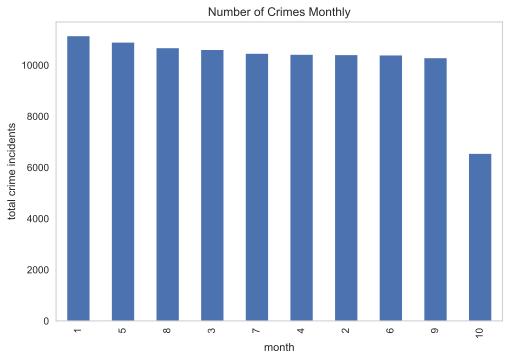

In [24]:
month_crime = crime2016_complete_df.groupby('month')['category'].count().sort_values(ascending=False)
month_crime_viz = month_crime.plot(kind='bar', title='Number of Crimes Monthly')
month_crime_viz.set_xlabel('month')
month_crime_viz.set_ylabel('total crime incidents')
month_crime_viz.grid(False)
plt.show()

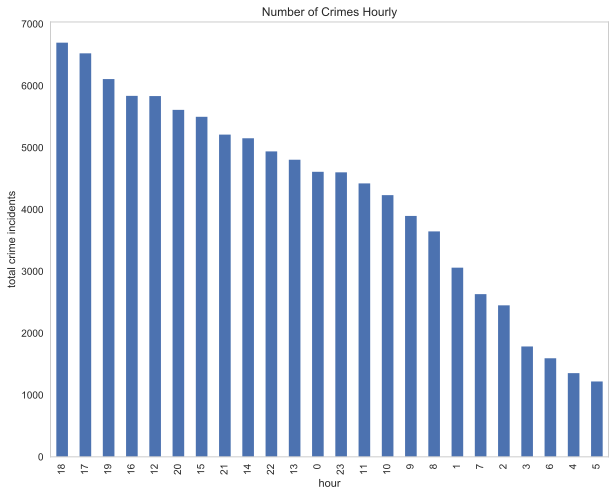

In [25]:
plt.figure(figsize=(10,8))
hour_crime = crime2016_complete_df.groupby('hour')['category'].count().sort_values(ascending=False)
hour_crime_viz = hour_crime.plot(kind='bar', title='Number of Crimes Hourly')
hour_crime_viz.set_xlabel('hour')
hour_crime_viz.set_ylabel('total crime incidents')
hour_crime_viz.grid(False)
plt.show()

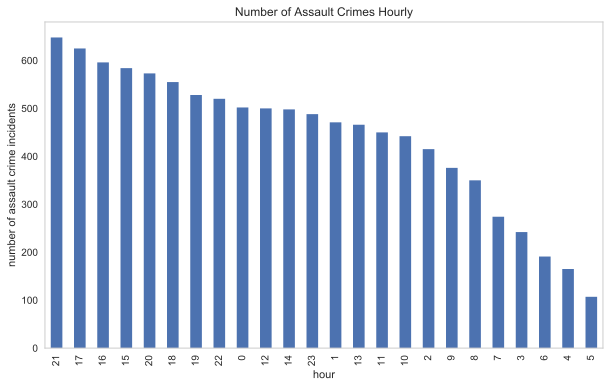

In [26]:
plt.figure(figsize=(10,6))
assault = crime2016_complete_df[crime2016_complete_df.category=='assault']
hour_assault = assault.groupby('hour')['category'].count().sort_values(ascending=False)
assault_viz = hour_assault.plot(kind='bar', title='Number of Assault Crimes Hourly')
assault_viz.set_xlabel('hour')
assault_viz.set_ylabel('number of assault crime incidents')
assault_viz.grid(False)
plt.show()

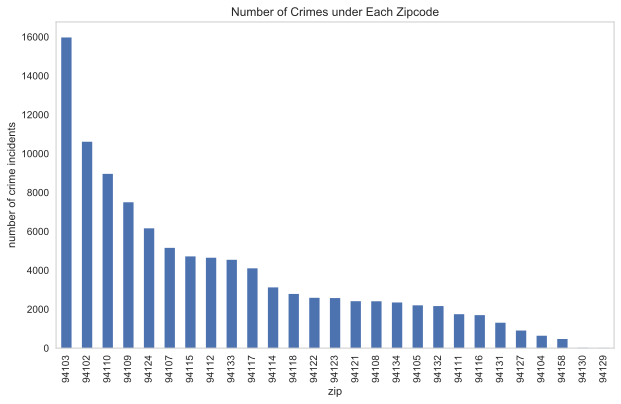

In [32]:
plt.figure(figsize=(10,6))
zip_crime = crime2016_complete_df.groupby('zipcode')['category'].count().sort_values(ascending=False)
zip_crime_viz = zip_crime.plot(kind='bar', title='Number of Crimes under Each Zipcode')
zip_crime_viz.set_xlabel('zip')
zip_crime_viz.set_ylabel('number of crime incidents')
zip_crime_viz.grid(False)
plt.show()

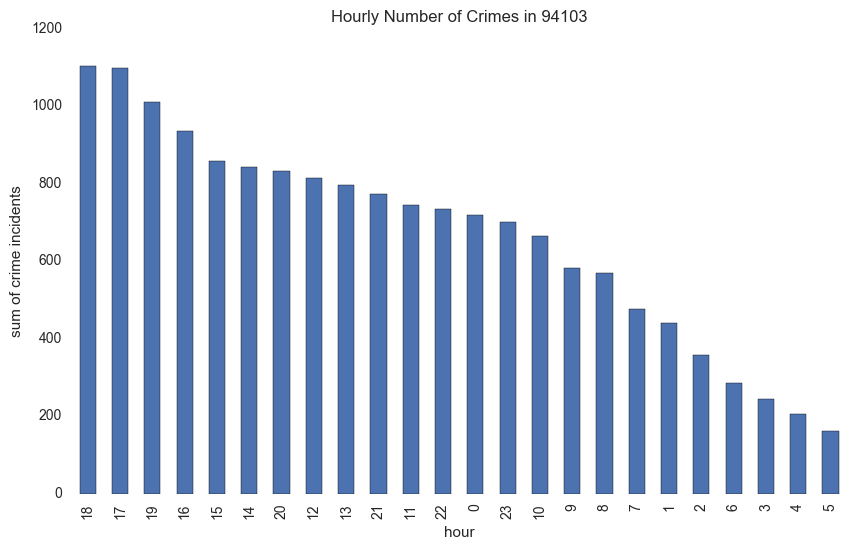

In [9]:
plt.figure(figsize=(10,6))
crime_94103 = crime2016_complete_df[crime2016_complete.zipcode == '94103']
crime_94103_hour = crime_94103.groupby('hour')['category'].count().sort_values(ascending=False)
crime_94103_hour_viz = crime_94103_hour.plot(kind='bar', title='Hourly Number of Crimes in 94103')
crime_94103_hour_viz.set_xlabel('hour')
crime_94103_hour_viz.set_ylabel('sum of crime incidents')
crime_94103_hour_viz.set_axis_bgcolor('white')
plt.show()

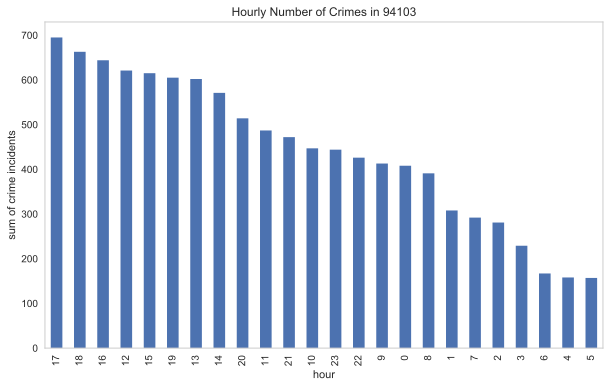

In [35]:
plt.figure(figsize=(10,6))
crime_94103 = crime2016_complete_df[crime2016_complete_df.zipcode == '94102']
crime_94103_hour = crime_94103.groupby('hour')['category'].count().sort_values(ascending=False)
crime_94103_hour_viz = crime_94103_hour.plot(kind='bar', title='Hourly Number of Crimes in 94103')
crime_94103_hour_viz.set_xlabel('hour')
crime_94103_hour_viz.set_ylabel('sum of crime incidents')
crime_94103_hour_viz.grid(False)
plt.show()

In [81]:
sf_demo_socio.head(1)

,zipcode,tol_pop_male,tol_pop_female,age10_14,age15_19,age20_24,age25_34,age35_44,age45_54,age55_59,...,age18_over_female,age65_over_male,age65_over_female,race_white,race_black,race_native,race_asian,race_hawaiian_pislander,race_others,race_his_lat
0,94102,15939,12074,361,1148,1672,6404,4418,4876,1857,...,10615,2015,2300,12032,3670,326,8652,122,1884,4779


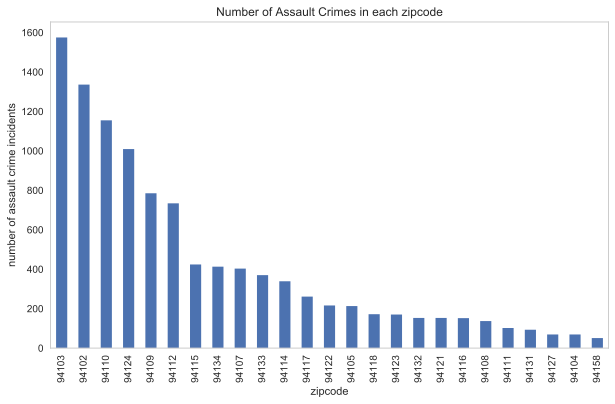

In [19]:
plt.figure(figsize=(10,6))
assault = crime2016_complete_df[crime2016_complete_df.category=='assault']
hour_assault = assault.groupby('zipcode')['category'].count().sort_values(ascending=False)
assault_viz = hour_assault.plot(kind='bar', title='Number of Assault Crimes in each zipcode')
assault_viz.set_xlabel('zipcode')
assault_viz.set_ylabel('number of assault crime incidents')
assault_viz.grid(False)
plt.show()

### Data Visualization

#### Plot out every crime incidents. This data visualization gives a general idea of where most crime incidents happened in San Francisco City

In [2]:
with open('../final_dataset/crime2016_origin_modified_col.pkl') as handle:
    crime2016 = pickle.load(handle)

In [3]:
zip_map = crime2016['zipcode'].value_counts().index

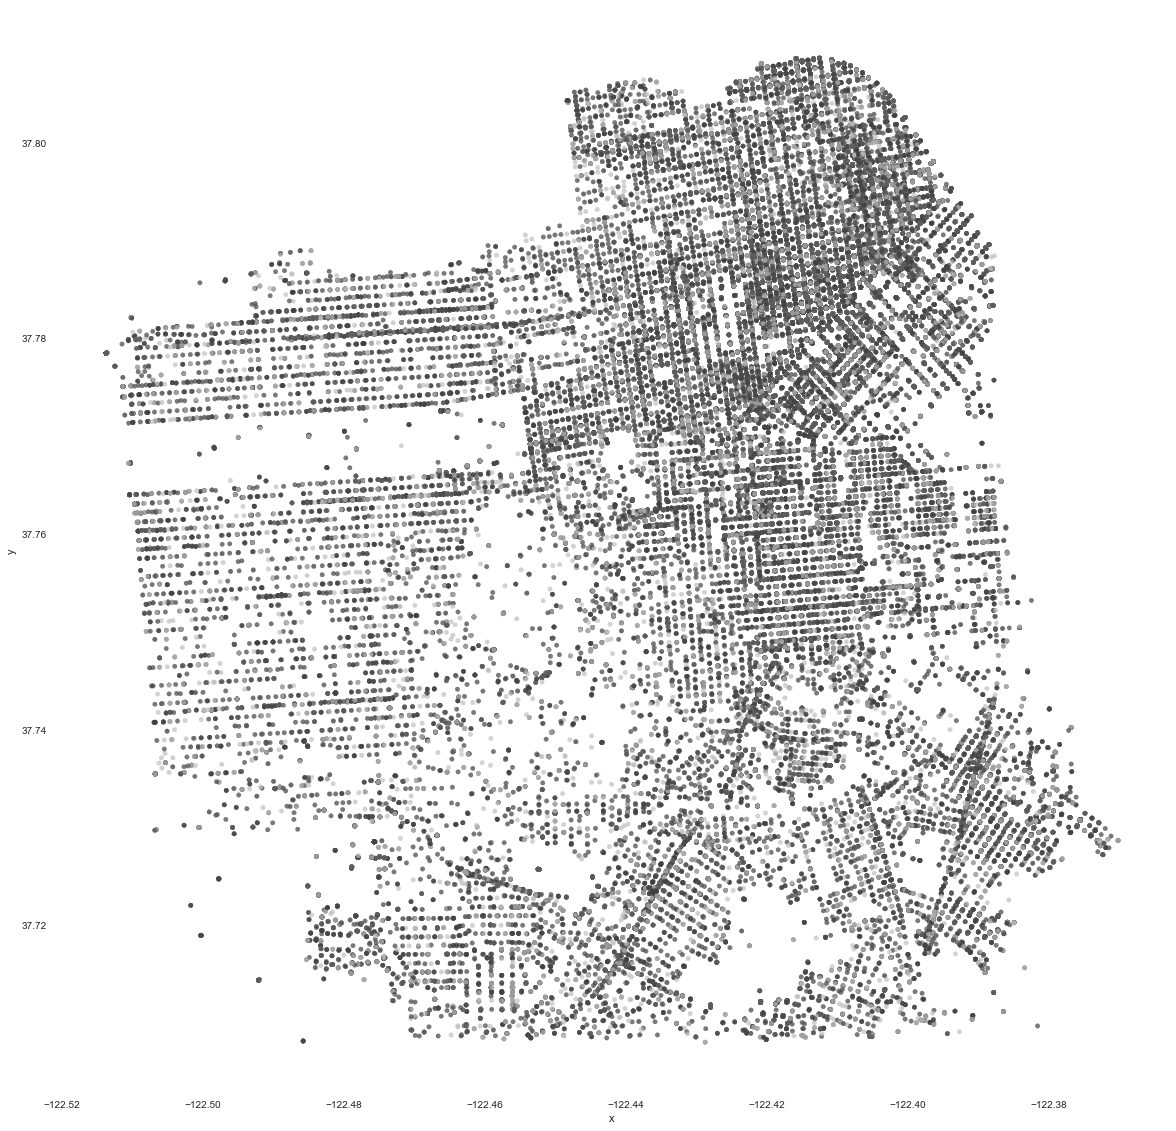

In [4]:
ax = plt.gca()
for z in zip_map:
    crime2016[crime2016['zipcode'] == z].plot('x', 'y', kind='scatter', figsize=(20,20),\
                                              alpha=0.7, c=['0.75','0.25','0.25'], ax=ax)

ax.set_facecolor('white')

In [52]:
#geopanda
#make graphs to show crime frequencies in each neighborhood/area

with open('../final_dataset/crime2016_origin_modified_col.pkl') as handle:
    crime2016 = pickle.load(handle)
sf = gpd.read_file('../map_visualization/2010_census_tracts_neighborhoods/census_tracts.shp')

In [53]:
sf.crs

{'init': u'epsg:4326'}

In [54]:
sf = sf.to_crs({'init': 'epsg:4326'})

In [55]:
sf['geometry'].head()

0    POLYGON ((-122.4324669997095 37.77375700028448...
1    POLYGON ((-122.4235409996432 37.77967400025458...
2    POLYGON ((-122.4246870001921 37.78533500040309...
3    POLYGON ((-122.4246870001921 37.78533500040309...
4    POLYGON ((-122.4349179998128 37.78587599994257...
Name: geometry, dtype: object

In [71]:
def assign_census_tract(df):
    bools = [geom.contains(df['geometry']) for geom in sf['geometry']]
    if True in bools:
        return sf.iloc[bools.index(True)]['tractce10']
    else:
        return np.nan

In [72]:
crime_drug = crime2016[crime2016.category == 'drug/narcotic']

In [73]:
crime_drug=crime_drug.reset_index(drop=True)

In [76]:
crime_drug['census_tract'] = crime_drug.apply(assign_census_tract, axis='columns')

In [79]:
sf['drug'] = sf['tractce10'].map(crime_drug['census_tract'].value_counts())
sf = sf.fillna(0)

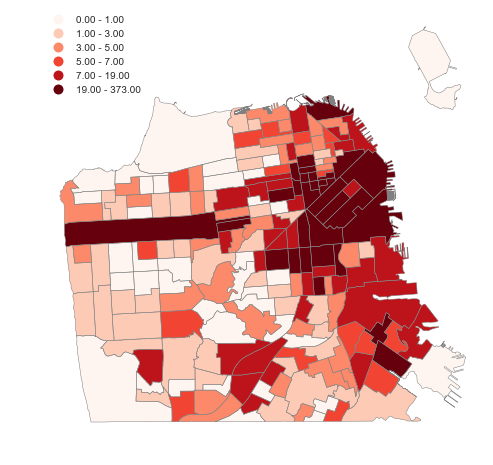

In [80]:
#drug crimes frequencies in each area
f = plt.figure(figsize=(8, 8))
ax = f.gca()
kw = dict(column='drug', k=6, cmap='Reds', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='QUANTILES', ax=ax, **kw)
ax.set_axis_off()

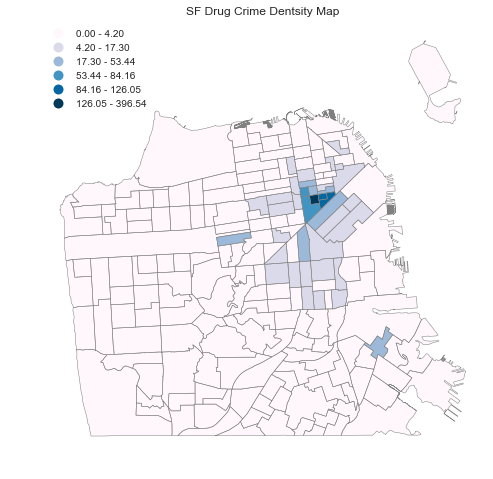

In [81]:
#drug crime density graph

sf['drugDensity'] = (sf['drug'] / (sf['geometry'].to_crs({'init': 'epsg:4326'}).map(lambda p: p.area*10**5))).fillna(0)

f = plt.figure(figsize=(8, 8))
ax = f.gca()
kw = dict(column='drugDensity', k=6, cmap='PuBu', alpha=1, legend=True, edgecolor='gray', linewidth=0.5)
sf.plot(scheme='Fisher_Jenks',ax=ax, **kw)
ax.set_title('SF Drug Crime Dentsity Map')
ax.set_axis_off()

### Predicting hourly number of crimes in April, May, and June, using previous three months' data (January, February, and March)

In [114]:
crime_jan_mar = crime[(crime.month == 1) | (crime.month == 2) | (crime.month == 3)]
crime_jan_mar_zipcode = crime_jan_mar.groupby(['zipcode', 'hour'])['category'].count().reset_index()
crime_jan_mar_zipcode = crime_jan_mar_zipcode.rename(columns={'category': 'number_of_crime'})

# find out missing values (because no crime happen at specific hour) 
# and fill in the hour of time and number of crime with 0
missing_94158_94104 = pd.DataFrame([['94158', 4, 0], ['94104', 3, 0], ['94104', 4, 0]], 
                                   columns=['zipcode', 'hour', 'number_of_crime'])
crime_jan_mar_zipcode = crime_jan_mar_zipcode.append(missing_94158_94104)

crime_jan_mar_complete = crime_jan_mar_zipcode.merge(sf_demo_socio,how='left',on='zipcode')

In [115]:
zip_dummy = pd.get_dummies(crime_jan_mar_complete['zipcode'])
crime_jan_mar_dum = pd.concat([zip_dummy, crime_jan_mar_complete], axis=1)
crime_jan_mar_dum = crime_jan_mar_dum.drop('zipcode', axis=1)

features = [col for col in crime_jan_mar_dum.columns if col != 'number_of_crime']

X_train, y_train = crime_jan_mar_dum[features], crime_jan_mar_dum['number_of_crime']
print X_train.shape, y_train.shape

(600, 51) (600,)


In [116]:
crime_apr_jun = crime[(crime.month == 4) | (crime.month == 5) | (crime.month ==6)]
crime_apr_jun_zipcode = crime_apr_jun.groupby(['zipcode', 'hour'])['category'].count().reset_index()
crime_apr_jun_zipcode = crime_apr_jun_zipcode.rename(columns={'category': 'number_of_crime'})

# find out missing values (because no crime happen at specific hour) 
# and fill in the hour of time and number of crime with 0
missing_94104_94127_94158 = pd.DataFrame([['94104', 2, 0], ['94127', 5, 0], ['94158', 4, 0]], 
                                         columns=['zipcode', 'hour', 'number_of_crime'])

crime_apr_jun_zipcode = crime_apr_jun_zipcode.append(missing_94104_94127_94158)
crime_apr_jun_complete = crime_apr_jun_zipcode.merge(sf_demo_socio, how='left', on='zipcode')

In [117]:
zip_dummy = pd.get_dummies(crime_apr_jun_complete['zipcode'])
crime_apr_jun_dum = pd.concat([zip_dummy, crime_apr_jun_complete], axis=1)
crime_apr_jun_dum = crime_apr_jun_dum.drop('zipcode', axis=1)

X_test, y_test = crime_apr_jun_dum[features], crime_apr_jun_dum['number_of_crime']
print X_test.shape, y_test.shape

(600, 51) (600,)


## July to September

In [118]:
crime_jul_sep = crime[(crime.month == 7) | (crime.month == 8) | (crime.month == 9)]
crime_jul_sep_zipcode = crime_jul_sep.groupby(['zipcode', 'hour'])['category'].count().reset_index()
crime_jul_sep_zipcode = crime_jul_sep_zipcode.rename(columns={'category': 'number_of_crime'})

In [119]:
# 94116 3am
crime_jul_sep_zipcode[crime_jul_sep_zipcode.zipcode == '94116']
missing_94116 = pd.DataFrame([['94116', 3, 0]], columns=['zipcode', 'hour', 'number_of_crime'])
crime_jul_sep_zipcode = crime_jul_sep_zipcode.append(missing_94116)

In [120]:
crime_jul_sep_complete = crime_jul_sep_zipcode.merge(sf_demo_socio, how='left', on='zipcode')

In [121]:
zip_dummy = pd.get_dummies(crime_jul_sep_complete['zipcode'])
crime_jul_sep_dum = pd.concat([zip_dummy, crime_jul_sep_complete], axis=1)
crime_jul_sep_dum = crime_jul_sep_dum.drop('zipcode', axis=1)

In [122]:
X_jul_test, y_jul_test = crime_jul_sep_dum[features], crime_jul_sep_dum['number_of_crime']
print X_jul_test.shape, y_jul_test.shape

(600, 51) (600,)


## Modeling
### Linear Regression

In [123]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [124]:
lr.score(X_train, y_train)

0.79388886967336192

In [125]:
lr.score(X_test, y_test)

0.78041361846572377

In [126]:
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)

print mse_lr, mae_lr

653.43838115 16.9920175169


In [127]:
lr_coef = pd.DataFrame(lr.coef_, index=X_train.columns, columns=['coef'])
lr_coef = lr_coef['coef'].sort_values(ascending=False)

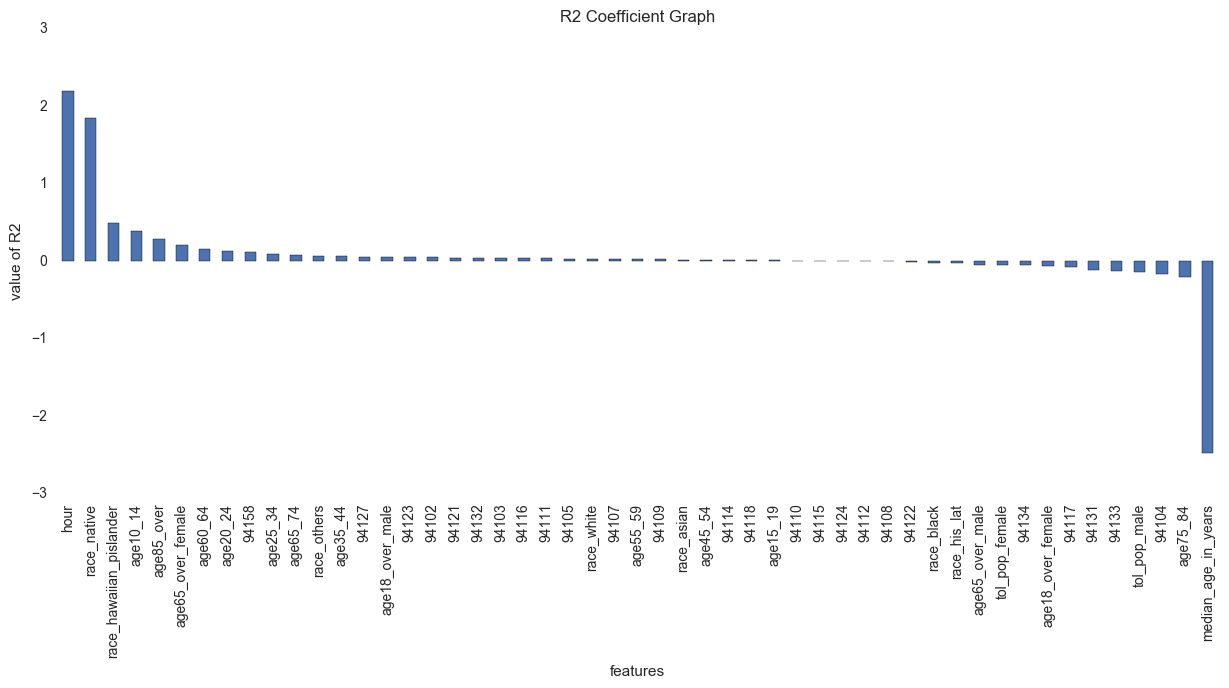

In [128]:
plt.figure(figsize=(15,6))
lr_coef_viz = lr_coef.plot(kind='bar', title='R2 Coefficient Graph')
lr_coef_viz.set_xlabel('features')
lr_coef_viz.set_ylabel('value of R2')
lr_coef_viz.set_axis_bgcolor('white')
plt.show()

In [130]:
lr_apr_jul = LinearRegression()

lr_apr_jul.fit(X_test, y_test)
y_jul_sep_pred = lr_apr_jul.predict(X_jul_test)

lr_apr_jul.score(X_jul_test, y_jul_test)

0.79348759205531394

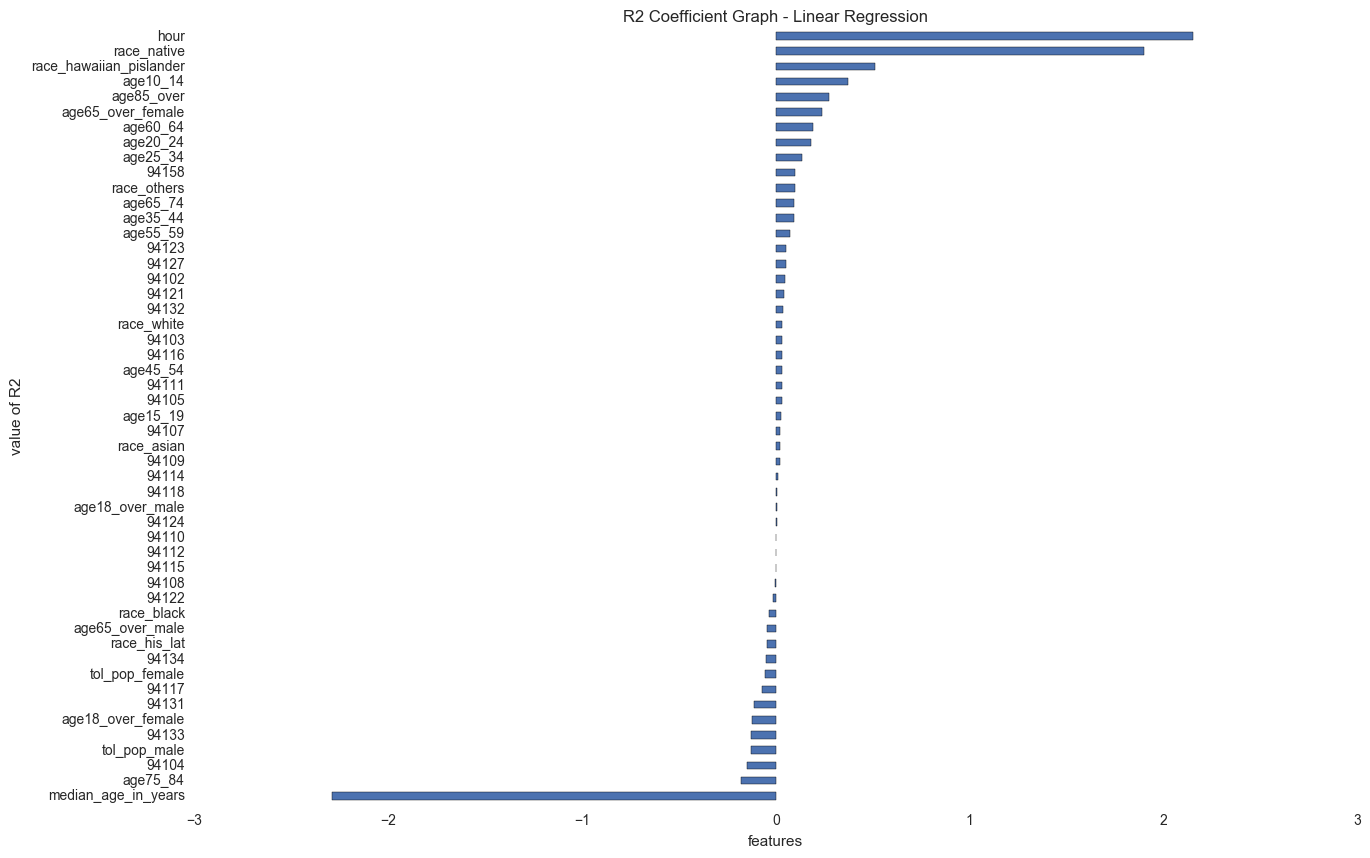

In [132]:
lr_coef_apr_jul = pd.DataFrame(lr_apr_jul.coef_, index=X_test.columns, columns=['coef'])
lr_coef_apr_jul = lr_coef_apr_jul['coef'].sort_values(ascending=True)
plt.figure(figsize=(15,10))
lr_coef_apr_jul_viz = lr_coef_apr_jul.plot(kind='barh', title='R2 Coefficient Graph - Linear Regression')
lr_coef_apr_jul_viz.set_xlabel('features')
lr_coef_apr_jul_viz.set_ylabel('value of R2')
lr_coef_apr_jul_viz.set_axis_bgcolor('white')
plt.show()

## Decision Tree Regressor

In [133]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_dtr_pred = dtr.predict(X_test)
dtr.score(X_test, y_test)

0.92196303279558456

In [137]:
mse_dt = mean_squared_error(y_test, y_dtr_pred)
mae_dt = mean_absolute_error(y_test, y_dtr_pred)

print 'mean square error: ', mse_dt, '\n', 'mean absolute error: ', mae_dt

mean square error:  232.22 
mean absolute error:  10.57


In [138]:
dtr_feat = pd.DataFrame(dtr.feature_importances_, index=X_test.columns, columns=['feat_imp'])
dtr_feat = dtr_feat['feat_imp'].sort_values(ascending=True)

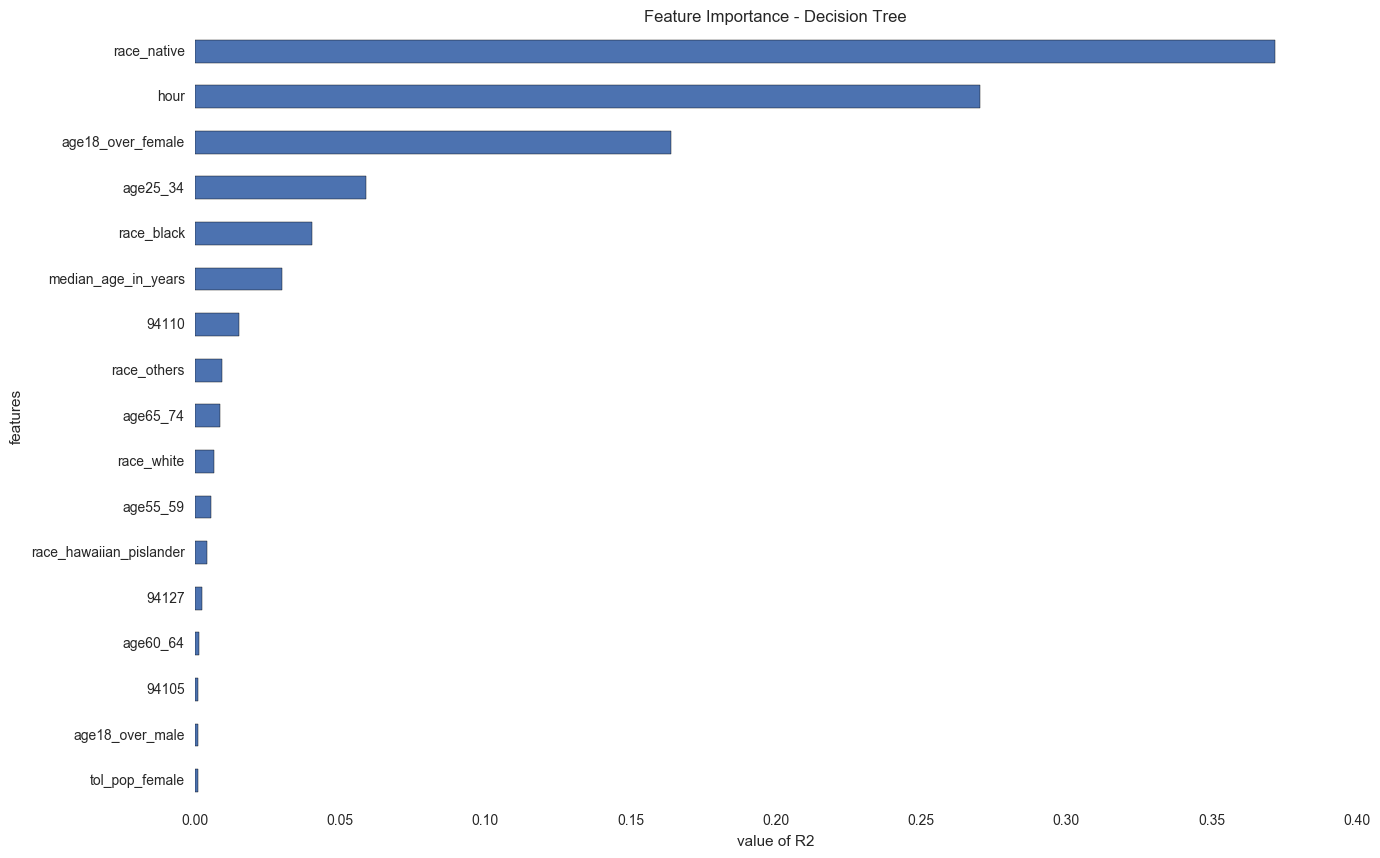

In [140]:
plt.figure(figsize=(15,10))
dtr_feat_viz = dtr_feat[34:].plot(kind='barh', title='Feature Importance - Decision Tree')
dtr_feat_viz.set_ylabel('features')
dtr_feat_viz.set_xlabel('value of R2')
dtr_feat_viz.set_axis_bgcolor('white')
plt.show()

## random forrest

In [142]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rfr.score(X_test, y_test)

0.93424255273027002

In [143]:
mse_rfr = mean_squared_error(y_test, y_pred)
mae_rfr = mean_absolute_error(y_test, y_pred)
print 'mean square error: ', mse_rfr, '\n', 'mean absolute error: ', mae_rfr

mean square error:  195.678983333 
mean absolute error:  9.4955


In [144]:
rfr_co = pd.DataFrame(rfr.feature_importances_)
rfr_co.index = X_train.columns
rfr_co = rfr_co.rename(columns={0:'feature_importances'})
rfr_co = rfr_co['feature_importances'].sort_values(ascending=True)

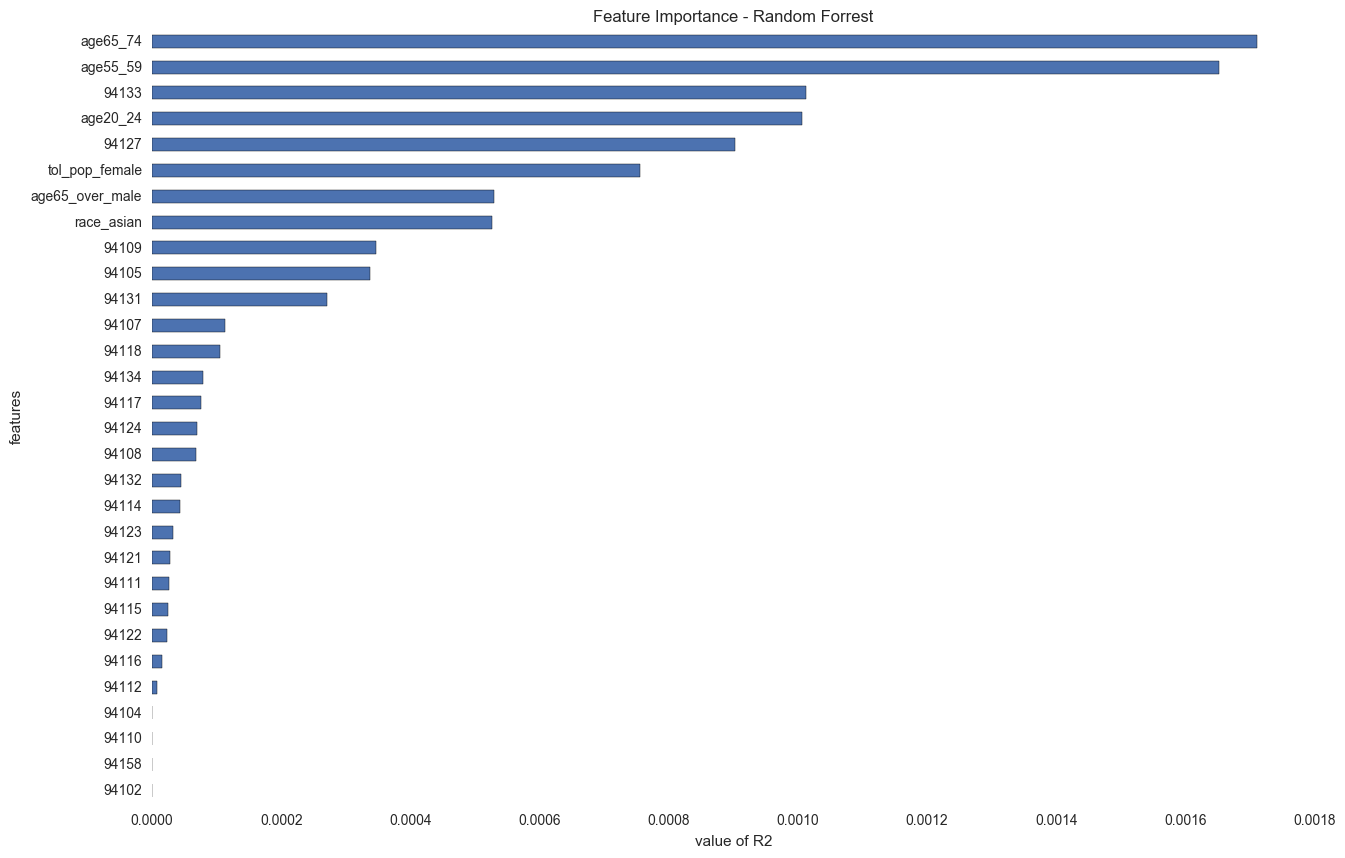

In [145]:
plt.figure(figsize=(15,10))
rfr_co_viz = rfr_co[:30].plot(kind='barh', title='Feature Importance - Random Forrest')
rfr_co_viz.set_ylabel('features')
rfr_co_viz.set_xlabel('value of R2')
rfr_co_viz.set_axis_bgcolor('white')
plt.show()

In [146]:
## use April-June to predict July-September

In [147]:
rfr1 = RandomForestRegressor()
rfr1.fit(X_test, y_test)
y_jul_pred = rfr1.predict(X_jul_test)
rfr1.score(X_jul_test, y_jul_test)

0.93704116552965067

In [148]:
mse_rfr1 = mean_squared_error(y_jul_test, y_jul_pred)
mae_rfr1 = mean_absolute_error(y_jul_test, y_jul_pred)
print 'mean square error: ', mse_rfr1, '\n', 'mean absolute error: ', mae_rfr1

mean square error:  177.962916667 
mean absolute error:  9.07983333333


## use first 12 hours to predict next 12 hours

In [149]:
first12 = (crime_jan_mar_complete.hour == 1) | (crime_jan_mar_complete.hour == 2) | (crime_jan_mar_complete.hour == 3) |\
          (crime_jan_mar_complete.hour == 4) | (crime_jan_mar_complete.hour == 5) | (crime_jan_mar_complete.hour == 6) |\
          (crime_jan_mar_complete.hour == 7) | (crime_jan_mar_complete.hour == 8) | (crime_jan_mar_complete.hour == 9) |\
          (crime_jan_mar_complete.hour == 10) | (crime_jan_mar_complete.hour == 11) | (crime_jan_mar_complete.hour == 12)

second12 = (crime_jan_mar_complete.hour == 13) | (crime_jan_mar_complete.hour == 14) | (crime_jan_mar_complete.hour == 15) |\
          (crime_jan_mar_complete.hour == 16) | (crime_jan_mar_complete.hour == 17) | (crime_jan_mar_complete.hour == 18) |\
          (crime_jan_mar_complete.hour == 19) | (crime_jan_mar_complete.hour == 20) | (crime_jan_mar_complete.hour == 21) |\
          (crime_jan_mar_complete.hour == 22) | (crime_jan_mar_complete.hour == 23) | (crime_jan_mar_complete.hour == 0)
jan_mar_frist12 = crime_jan_mar_complete[first12]
jan_mar_second12 = crime_jan_mar_complete[second12]

In [150]:
def dummies(df):
    zip_dummy = pd.get_dummies(df['zipcode'])
    df_dum = pd.concat([zip_dummy, df], axis=1)
    df_dum = df_dum.drop('zipcode', axis=1)
    return df_dum

In [151]:
def get_features(df):
    features = [col for col in df.columns if col != 'number_of_crime']
    return features

jan_mar_frist12_dum = dummies(jan_mar_frist12)
jan_mar_second12_dum = dummies(jan_mar_second12)

features = get_features(jan_mar_frist12_dum)

X_jan_train = jan_mar_frist12_dum[features]
y_jan_train = jan_mar_frist12_dum['number_of_crime']
X_jan_test = jan_mar_second12_dum[features]
y_jan_test = jan_mar_second12_dum['number_of_crime']

In [152]:
rfr_12 = RandomForestRegressor()
rfr_12.fit(X_jan_train, y_jan_train)
y_12_pred = rfr_12.predict(X_jan_test)
rfr_12.score(X_jan_test, y_jan_test)

0.8650756998794783

In [153]:
print 'mean squared error: ', mean_squared_error(y_jan_test, y_12_pred),'\n',\
      'mean absolute error: ', mean_absolute_error(y_jan_test, y_12_pred)

mean squared error:  452.154566667 
mean absolute error:  15.641


In [154]:
## april to june
first12 = (crime_apr_jun_complete.hour == 1) | (crime_apr_jun_complete.hour == 2) | (crime_apr_jun_complete.hour == 3) |\
          (crime_apr_jun_complete.hour == 4) | (crime_apr_jun_complete.hour == 5) | (crime_apr_jun_complete.hour == 6) |\
          (crime_apr_jun_complete.hour == 7) | (crime_apr_jun_complete.hour == 8) | (crime_apr_jun_complete.hour == 9) |\
          (crime_apr_jun_complete.hour == 10) | (crime_apr_jun_complete.hour == 11) | (crime_apr_jun_complete.hour == 12)

second12 = (crime_apr_jun_complete.hour == 13) | (crime_apr_jun_complete.hour == 14) | (crime_apr_jun_complete.hour == 15) |\
          (crime_apr_jun_complete.hour == 16) | (crime_apr_jun_complete.hour == 17) | (crime_apr_jun_complete.hour == 18) |\
          (crime_apr_jun_complete.hour == 19) | (crime_apr_jun_complete.hour == 20) | (crime_apr_jun_complete.hour == 21) |\
          (crime_apr_jun_complete.hour == 22) | (crime_apr_jun_complete.hour == 23) | (crime_apr_jun_complete.hour == 0)
apr_jun_frist12 = crime_apr_jun_complete[first12]
apr_jun_second12 = crime_apr_jun_complete[second12]

In [155]:
apr_jun_frist12_dum = dummies(apr_jun_frist12)
apr_jun_second12_dum = dummies(apr_jun_second12)

features = get_features(apr_jun_frist12_dum)

X_apr_train = apr_jun_frist12_dum[features]
y_apr_train = apr_jun_frist12_dum['number_of_crime']
X_apr_test = apr_jun_second12_dum[features]
y_apr_test = apr_jun_second12_dum['number_of_crime']

In [156]:
rfr_apr = RandomForestRegressor()
rfr_apr.fit(X_apr_train, y_apr_train)
y_apr_pred = rfr_apr.predict(X_apr_test)

In [157]:
rfr_apr.score(X_apr_test, y_apr_test)

0.86284597537639829